## SRME1

![SRME method](../images/SRME_method.png)

This notebook is an implementation of SRME1

Reference:
1. (https://github.com/DIG-Kaust/Adaptive-subtraction/blob/master/notebooks/Multiples_Prediction.ipynb)
2. [多次波分离与成像方法研究-李志娜-博士论文](http://kns-cnki-net-s.vpn.cdut.edu.cn:8118/kcms2/article/abstract?v=1i9K2Vab0pPLZfwCMX6yR0lFRhl6QO2DKjIUz3H8b10Lji36qmhb8E8bKAbLRZ5EDhgr65mEMr_4fNxMaFctnC4_X5WxoagzEO2l77J9TEoUm6H5kYczH_aeVVOO4BXA48NEWG692VKMWUGkh5Md6Q==&uniplatform=NZKPT&language=CHS)

###  1.input seismic data $p(x_s, x_r, t)$

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
import pylops
import sys
sys.path.append('../')
plt.style.use('default')

In [33]:
data = np.load('../data/data_free.npz')['arr_0']
data.shape

(101, 101, 1202)

In [34]:
data = data[:, :, :800]

ns = data.shape[0]  # number of sources
nr = data.shape[1]  # receivers
nt = data.shape[2]  # time sample

dt = 1              # time interval (ms)
dx = 12             # space interval (m)
isrc = (ns // 2)+1  # middle source
data.shape

(101, 101, 800)

### 2.cut the direct wave

In [35]:
from uilts.mutter import mutter

data_mutter = np.zeros_like(data)
input = data.copy()
for index in range(ns):
    # depth : 5m
    # the first layer velocity: 3km/s
    # the delta : 100
    data_mutter[index, :, :] = mutter(input[index, :, :], index, 5, 3, 3, 100)

(np.float64(0.0), np.float64(101.0), np.float64(0.8), np.float64(0.0))

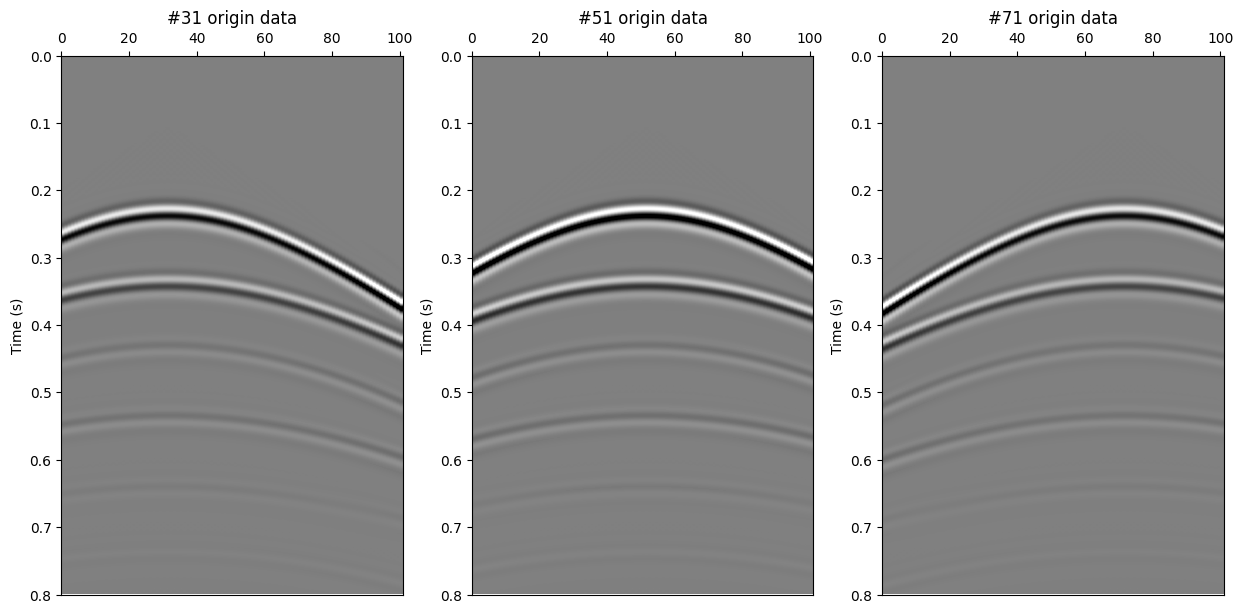

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(15, 7))

pclip = 0.7
axs[0].imshow(
    data_mutter[isrc - 20, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(data_mutter[isrc - 20, :, :]).max(),
    vmax=pclip * np.abs(data_mutter[isrc - 20, :, :]).max(),
    extent=(0, nr, nt*dt*1e-3, 0)
)
axs[0].set(ylabel="Time (s)", title="#31 origin data")
axs[0].xaxis.set_ticks_position('top')
axs[0].axis("tight")

axs[1].imshow(
    data_mutter[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(data_mutter[isrc, :, :]).max(),
    vmax=pclip * np.abs(data_mutter[isrc, :, :]).max(),
    extent=(0, nr, nt*dt*1e-3, 0)
)
axs[1].set(ylabel="Time (s)", title="#51 origin data")
axs[1].xaxis.set_ticks_position('top')
axs[1].axis("tight")

axs[2].imshow(
    data_mutter[isrc + 20, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(data_mutter[isrc + 20, :, :]).max(),
    vmax=pclip * np.abs(data_mutter[isrc + 20, :, :]).max(),
    extent=(0, nr, nt*dt*1e-3, 0)
)
axs[2].set(ylabel="Time (s)", title="#71 origin data")
axs[2].xaxis.set_ticks_position('top')
axs[2].axis("tight")

### 3. data pre-processing

In order to avoid wrap-around effects, we will do pre-processing on the data.

#### 3.1 Padding

In [37]:
p = 3  # 通过p来分割数据的最后一维，并进行填充
data_p = np.concatenate((data_mutter, np.zeros((data_mutter.shape[0],
                                                data_mutter.shape[1],
                                                data_mutter.shape[2] // p))), axis=-1)
data_p.shape

(101, 101, 1066)

#### 3.2 Smooth along interface

In [38]:
smoother = np.ones_like(data_p[0])   # shape of 1 CSG

M = 200  # number of samples before the interface
n = np.arange(0, M)
theta = n * (np.pi/2) / M
semi_hann = np.cos(theta)  # sinusoidal taper

for i in range(smoother.shape[0]):
    smoother[i, p*smoother.shape[1]//(p+1) - M: p*smoother.shape[1]//(p+1)] = semi_hann
    smoother[i, p*smoother.shape[1]//(p+1): smoother.shape[1]] *= 0

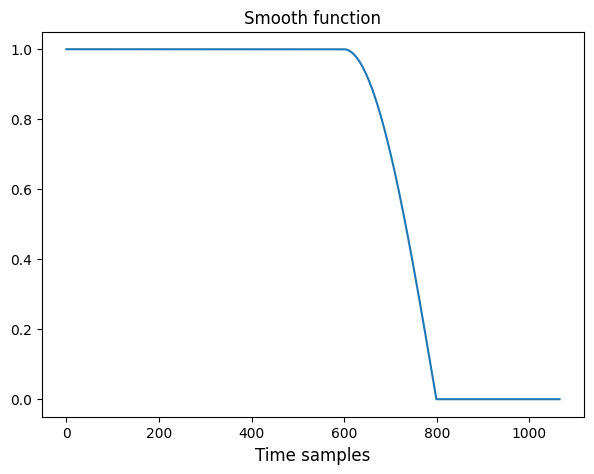

In [39]:
fig, axs = plt.subplots(1, 1, figsize=(7, 5))

axs.plot(smoother[100])
axs.set_xlabel('Time samples', fontsize=12)
axs.set_title('Smooth function')

plt.show()

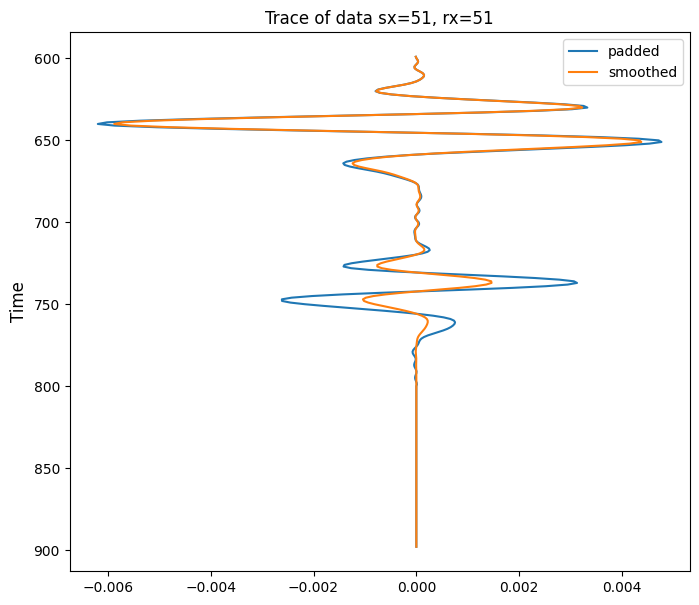

In [40]:
# Apply smooth function to padded data

data_s = np.multiply(data_p, smoother[np.newaxis])

# Plot a trace and compare it with the original 

fig, ax = plt.subplots(1, 1, figsize=(8,7))

sx, rx = 51, 51

y = np.arange(3*smoother.shape[1]//4 - M,3*smoother.shape[1]//4 + 100)*dt

ax.plot(data_p[sx, rx, p*smoother.shape[1]//(p+1) - M: p*smoother.shape[1]//(p+1) + 100], y, label='padded')
ax.plot(data_s[sx, rx, p*smoother.shape[1]//(p+1) - M: p*smoother.shape[1]//(p+1) + 100], y, label='smoothed')
ax.invert_yaxis()
ax.set_ylabel('Time', fontsize=12)
ax.set_title(f'Trace of data sx={sx}, rx={rx}')

plt.legend()
plt.show()

(np.float64(0.0), np.float64(101.0), np.float64(0.8), np.float64(0.0))

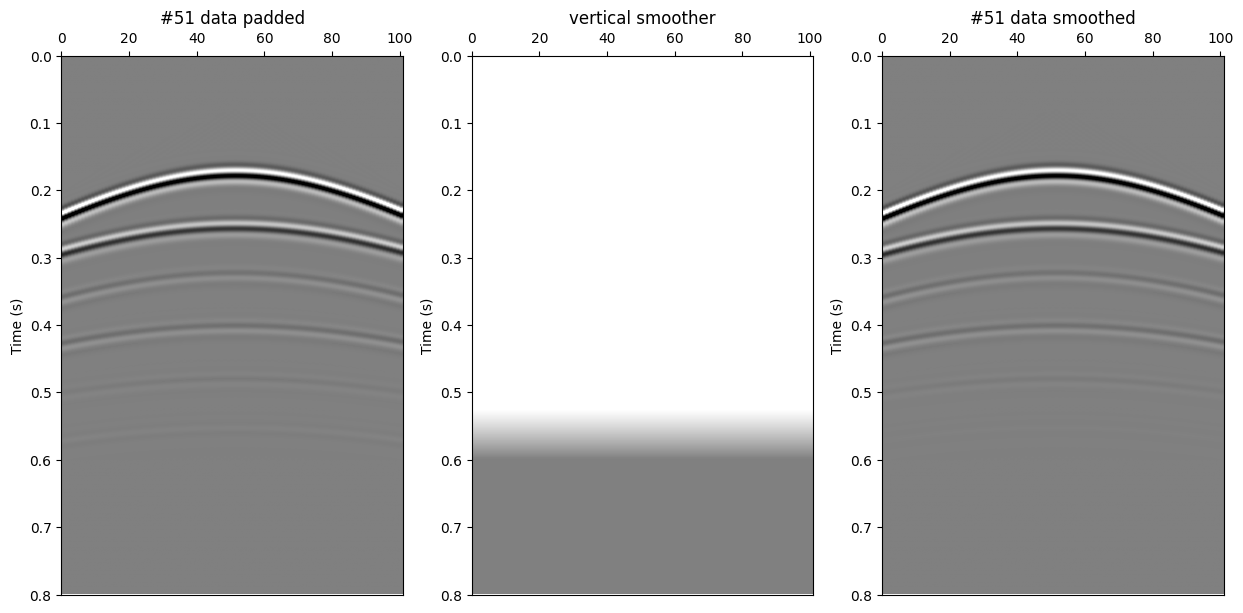

In [41]:
fig, axs = plt.subplots(1, 3, figsize=(15, 7))

axs[0].imshow(
    data_p[isrc,: , :].T,
    cmap="gray",
    vmin=-pclip * np.abs(data_p[isrc,: , :]).max(),
    vmax=pclip * np.abs(data_p[isrc,: , :]).max(),
    extent=(0, nr, nt*dt*1e-3, 0)
)
axs[0].set(ylabel="Time (s)", title="#51 data padded")
axs[0].xaxis.set_ticks_position('top')
axs[0].axis("tight")

axs[1].imshow(
    smoother.T,
    cmap="gray",
    vmin=-pclip * np.abs(smoother).max(),
    vmax=pclip * np.abs(smoother).max(),
    extent=(0, nr, nt*dt*1e-3, 0)
)
axs[1].set(ylabel="Time (s)", title="vertical smoother")
axs[1].xaxis.set_ticks_position('top')
axs[1].axis("tight")

axs[2].imshow(
    data_s[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(data_s[isrc, :, :]).max(),
    vmax=pclip * np.abs(data_s[isrc, :, :]).max(),
    extent=(0, nr, nt*dt*1e-3, 0)
)
axs[2].set(ylabel="Time (s)", title="#51 data smoothed")
axs[2].xaxis.set_ticks_position('top')
axs[2].axis("tight")

#### 3.3 Horizontal Taper (along receiver axis)

In [42]:
h_taper = np.ones_like(data_s[0])

M = 20
n = np.arange(0, M)
theta = n * (np.pi/2) / M
semi_hann_l = np.sin(theta)  # left side
semi_hann_r = np.cos(theta)  # right side

for i in range(h_taper.shape[1]):
    h_taper[:M, i] = semi_hann_l
    h_taper[-M:, i] = semi_hann_r

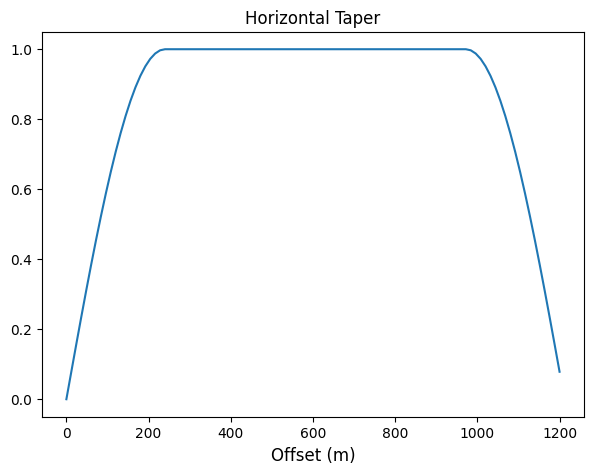

In [43]:
fig, axs = plt.subplots(1, 1, figsize=(7,5))

x = np.arange(data_s.shape[1])*dx

axs.plot(x, h_taper[:, 1000])
axs.set_xlabel('Offset (m)', fontsize=12)
axs.set_title(f'Horizontal Taper')

plt.show()

In [44]:
# Apply horizontal taper to smoothed data

data_t = np.multiply(data_s, h_taper[np.newaxis])

(np.float64(0.0), np.float64(101.0), np.float64(0.8), np.float64(0.0))

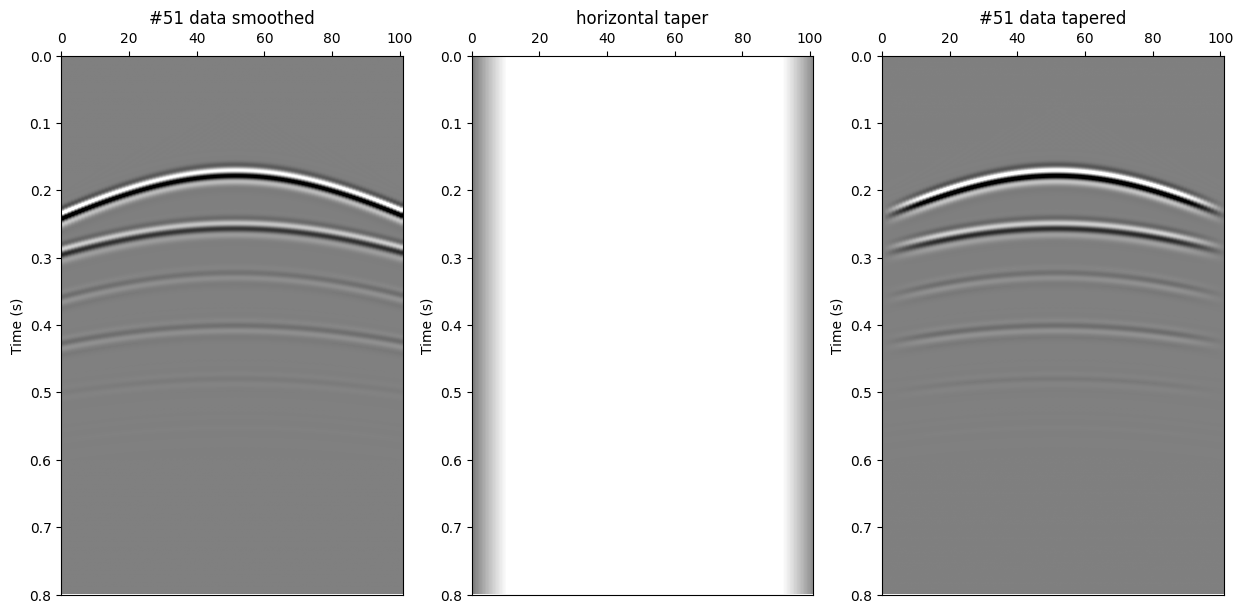

In [45]:
fig, axs = plt.subplots(1, 3, figsize=(15, 7))

axs[0].imshow(
    data_s[isrc,: , :].T,
    cmap="gray",
    vmin=-pclip * np.abs(data_s[isrc,: , :]).max(),
    vmax=pclip * np.abs(data_s[isrc,: , :]).max(),
    extent=(0, nr, nt*dt*1e-3, 0)
)
axs[0].set(ylabel="Time (s)", title="#51 data smoothed")
axs[0].xaxis.set_ticks_position('top')
axs[0].axis("tight")

axs[1].imshow(
    h_taper.T,
    cmap="gray",
    vmin=-pclip * np.abs(h_taper).max(),
    vmax=pclip * np.abs(h_taper).max(),
    extent=(0, nr, nt*dt*1e-3, 0)
)
axs[1].set(ylabel="Time (s)", title="horizontal taper")
axs[1].xaxis.set_ticks_position('top')
axs[1].axis("tight")

axs[2].imshow(
    data_t[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(data_t[isrc, :, :]).max(),
    vmax=pclip * np.abs(data_t[isrc, :, :]).max(),
    extent=(0, nr, nt*dt*1e-3, 0)
)
axs[2].set(ylabel="Time (s)", title="#51 data tapered")
axs[2].xaxis.set_ticks_position('top')
axs[2].axis("tight")

### 4. Transform data into frequency domain

Constructing the Berkhout matrix $P(x_s, x_r, w)$

In [46]:
data_fft_t = np.fft.rfft(data_t, axis=-1)  # time axis
data_fft_p = np.fft.rfft(data_p, axis=-1)

# Cast the type to complex64 to alocate only half of the array size
data_fft_t = data_fft_t.transpose(2, 0, 1).astype(np.complex64)
data_fft_p = data_fft_p.transpose(2, 0, 1).astype(np.complex64)

print(np.min(data_fft_p), np.max(data_fft_p))

(-7.9339128+0.24701652j) (8.098442-1.8825295j)


### MDC

To generate the model, we'll employ the Multi-Dimensional Convolution (MDC) function from pylops.

note: data must be 3D $(ns, nr, nt)$

In [47]:
# Create the multi-dimensional convolution operator
MDCop_t = pylops.waveeqprocessing.MDC(
    data_fft_t,
    nt=data_t.shape[2],      # number of time samples
    nv=data_t.shape[0],      # number of sources
    dt=dt,
    dr=dx,
    twosided = False,
)
MDCop_t.shape

/home/wwd/miniconda3/envs/pytorch1_13/lib/python3.10/site-packages/pylops/signalprocessing/fft.py:53: UserWarning: numpy backend always returns complex128 dtype. To respect the passed dtype, data will be casted to complex64.
  warnings.warn(


(10874266, 10874266)

In [48]:
# Create the multi-dimensional convolution operator
MDCop_p = pylops.waveeqprocessing.MDC(
    data_fft_p,
    nt=data_p.shape[2],      # number of time samples
    nv=data_p.shape[0],      # number of sources
    dt=dt,
    dr=dx,
    twosided = False,
)
MDCop_p.shape

(10874266, 10874266)

In [49]:
multiples_t =  MDCop_t @ data_t.transpose(2, 1, 0).ravel()
multiples_p =  MDCop_p @ data_p.transpose(2, 1, 0).ravel()

In [50]:
multiples_t = multiples_t.reshape(data_t.shape[2], ns, nr)
multiples_t = multiples_t.transpose(1, 2, 0)
multiples_t = multiples_t[:,:, :data.shape[2]]
multiples_t.shape

(101, 101, 800)

In [51]:
multiples_p = multiples_p.reshape(data_p.shape[2], ns, nr)
multiples_p = multiples_p.transpose(1, 2, 0)
multiples_p = multiples_p[:,:, :data.shape[2]]
multiples_p.shape

(101, 101, 800)

In [52]:
del data_fft_p, data_fft_t, data_p, data_s, data_t

### 5. Shift and Normalization

In [53]:
print(' Min of multiples_t:', np.min(multiples_t), '\n', 'Max of multiples_t:', 
      np.max(multiples_t), '\n', 'Mean of Multiples_t', np.mean(multiples_t))
print('\n')
print(' Min of multiples_p:', np.min(multiples_p), '\n', 'Max of multiples_p:', 
      np.max(multiples_p), '\n', 'Mean of Multiples_p', np.mean(multiples_p))
print('\n')
print(' Min of data_mutter:', np.min(data_mutter), '\n', 'Max of data_mutter:', 
      np.max(data_mutter), '\n', 'Mean of data_mutter', np.mean(data_mutter))

 Min of multiples_t: -4607.007 
 Max of multiples_t: 3449.023 
 Mean of Multiples_t -0.2823216


 Min of multiples_p: -4600.133 
 Max of multiples_p: 3408.227 
 Mean of Multiples_p -0.28825194


 Min of data_mutter: -0.33821666 
 Max of data_mutter: 0.28884816 
 Mean of data_mutter 1.3444323e-09


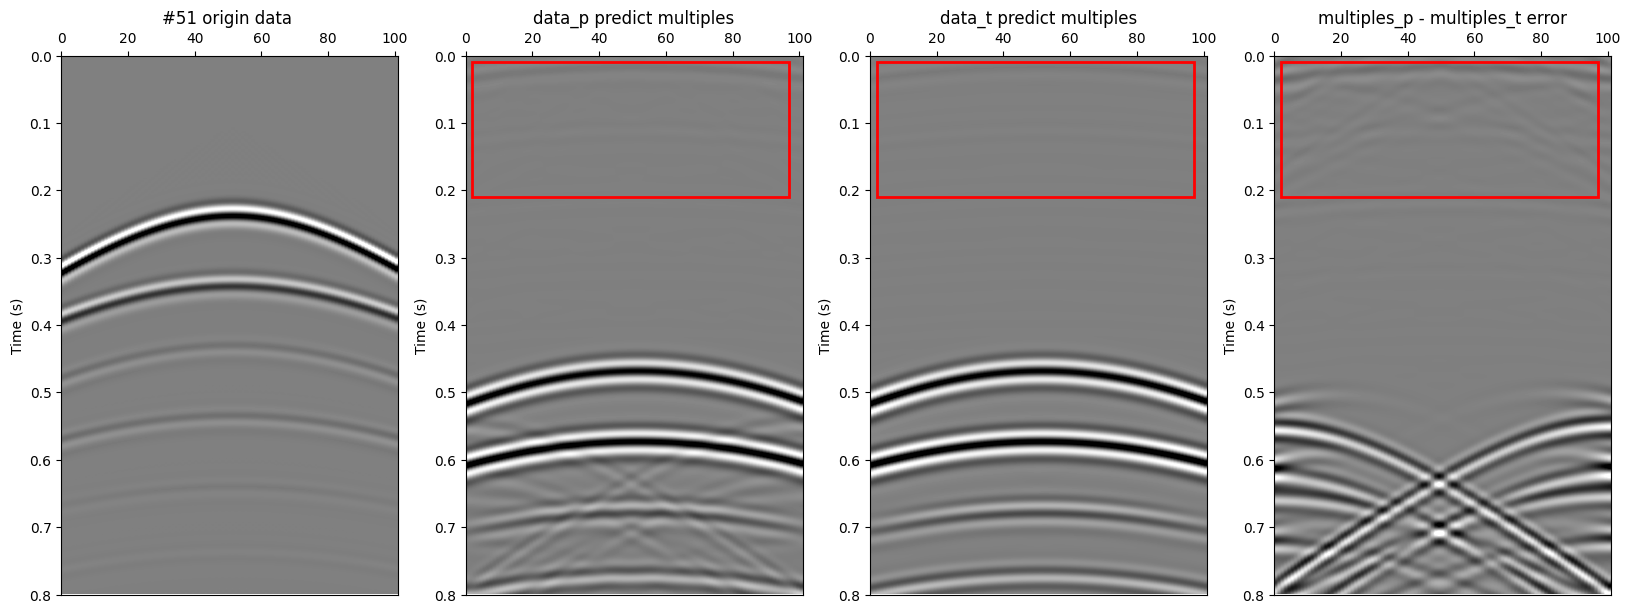

In [54]:
fig, axs = plt.subplots(1, 4, figsize=(20, 7))
from matplotlib.patches import Rectangle

axs[0].imshow(
    data_mutter[isrc,: , :].T,
    cmap="gray",
    vmin=-pclip * np.abs(data_mutter[isrc, :, :]).max(),
    vmax=pclip * np.abs(data_mutter[isrc, :, :]).max(),
    extent=(0, nr, nt*dt*1e-3, 0)
)
axs[0].set(ylabel="Time (s)", title="#51 origin data ")
axs[0].xaxis.set_ticks_position('top')
axs[0].axis("tight")

axs[1].imshow(
    multiples_p[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(multiples_p[isrc, :, :]).max(),
    vmax=pclip * np.abs(multiples_p[isrc, :, :]).max(),
    extent=(0, nr, nt*dt*1e-3, 0)
)
axs[1].set(ylabel="Time (s)", title="data_p predict multiples")
axs[1].xaxis.set_ticks_position('top')
axs[1].axis("tight")
rect_p = Rectangle((2, 0.01), 95, 0.2, linewidth=2, edgecolor='red', facecolor='none')
axs[1].add_patch(rect_p)


axs[2].imshow(
    multiples_t[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(multiples_t[isrc, :, :]).max(),
    vmax=pclip * np.abs(multiples_t[isrc, :, :]).max(),
    extent=(0, nr, nt*dt*1e-3, 0)
)
axs[2].set(ylabel="Time (s)", title="data_t predict multiples")
axs[2].xaxis.set_ticks_position('top')
axs[2].axis("tight")

rect_p = Rectangle((2, 0.01), 95, 0.2, linewidth=2, edgecolor='red', facecolor='none')
axs[2].add_patch(rect_p)

error = multiples_p - multiples_t
axs[3].imshow(
    error[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(error[isrc, :, :]).max(),
    vmax=pclip * np.abs(error[isrc, :, :]).max(),
    extent=(0, nr, nt*dt*1e-3, 0)
)
axs[3].set(ylabel="Time (s)", title="multiples_p - multiples_t error")
axs[3].xaxis.set_ticks_position('top')
axs[3].axis("tight")

rect_p = Rectangle((2, 0.01), 95, 0.2, linewidth=2, edgecolor='red', facecolor='none')
axs[3].add_patch(rect_p)

In [55]:
# multiples_p = multiples_p[:, :, int(0.4/dt/1e-3):]
# multiples_p = np.concatenate((np.ones((multiples_p.shape[0], multiples_p.shape[1], 
#                                      int(0.4/dt/1e-3)))*1e-13, multiples_p), axis=-1)

# multiples_t = multiples_t[:, :, int(0.4/dt/1e-3):]
# multiples_t = np.concatenate((np.ones((multiples_t.shape[0], multiples_t.shape[1], 
#                                      int(0.4/dt/1e-3)))*1e-13, multiples_t), axis=-1)

multiples_p[:, :, :400] = 1e-13
multiples_t[:, :, :400] = 1e-13

In [56]:
# Normalize overestimated multiples 
# 0.1 is a trick(will be modified)
multiples_t *= -0.8 * np.max(np.abs(data)) / np.max(abs(multiples_t)) * 0.1
multiples_p *= -0.8 * np.max(np.abs(data)) / np.max(abs(multiples_p)) * 0.1

print(' Min of multiples_t:', np.min(multiples_t), '\n', 'Max of multiples_t:', 
      np.max(multiples_t), '\n', 'Mean of Multiples_t', np.mean(multiples_t))
print('\n')
print(' Min of multiples_p:', np.min(multiples_p), '\n', 'Max of multiples_p:', 
      np.max(multiples_p), '\n', 'Mean of Multiples_p', np.mean(multiples_p))

 Min of multiples_t: -0.22501764 
 Max of multiples_t: 0.30056563 
 Mean of Multiples_t 2.4125196e-05


 Min of multiples_p: -0.22268835 
 Max of multiples_p: 0.30056563 
 Mean of Multiples_p 2.7477383e-05


(np.float64(0.0), np.float64(101.0), np.float64(0.8), np.float64(0.0))

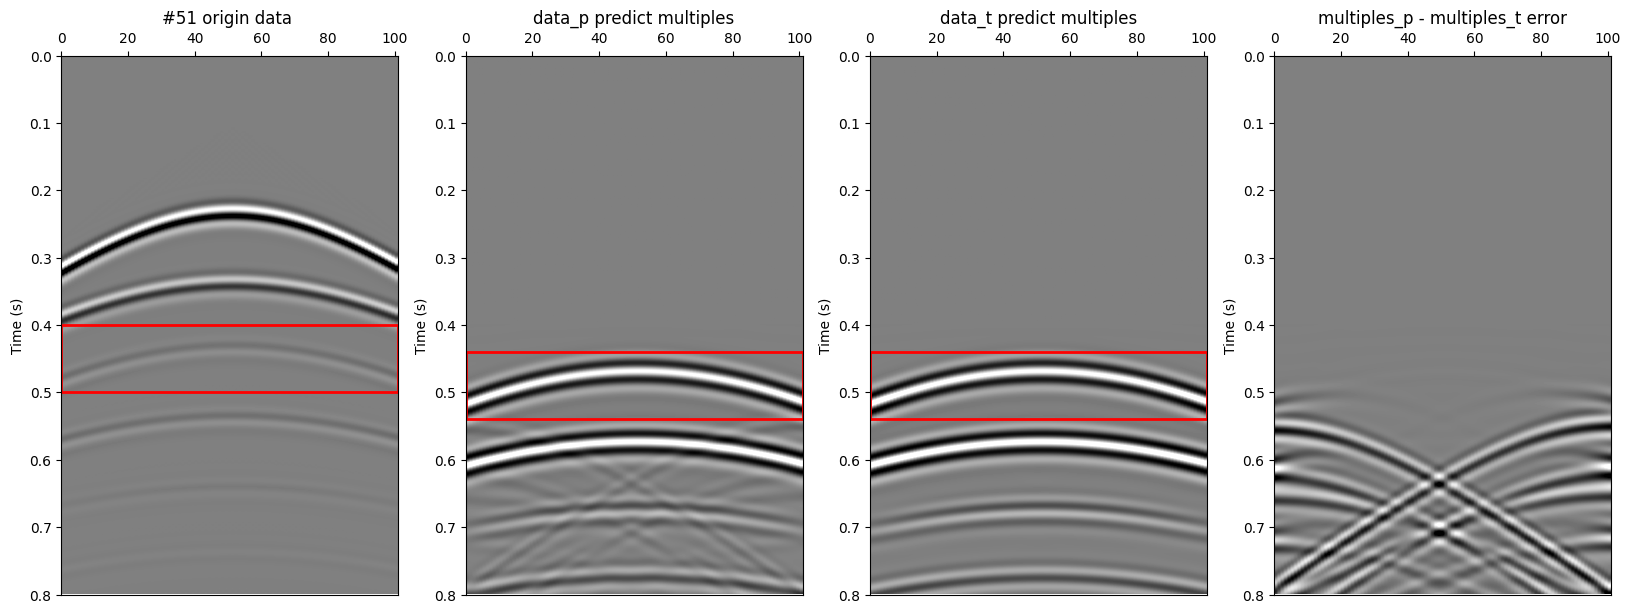

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 7))

axs[0].imshow(
    data_mutter[isrc,: , :].T,
    cmap="gray",
    vmin=-pclip * np.abs(data_mutter[isrc, :, :]).max(),
    vmax=pclip * np.abs(data_mutter[isrc, :, :]).max(),
    extent=(0, nr, nt*dt*1e-3, 0)
)
axs[0].set(ylabel="Time (s)", title="#51 origin data ")
axs[0].xaxis.set_ticks_position('top')
axs[0].axis("tight")

rect_p = Rectangle((0, 0.40), 101, 0.1, linewidth=2, edgecolor='red', facecolor='none')
axs[0].add_patch(rect_p)

axs[1].imshow(
    multiples_p[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(multiples_p[isrc, :, :]).max(),
    vmax=pclip * np.abs(multiples_p[isrc, :, :]).max(),
    extent=(0, nr, nt*dt*1e-3, 0)
)
axs[1].set(ylabel="Time (s)", title="data_p predict multiples")
axs[1].xaxis.set_ticks_position('top')
axs[1].axis("tight")
rect_p = Rectangle((0, 0.44), 101, 0.1, linewidth=2, edgecolor='red', facecolor='none')
axs[1].add_patch(rect_p)

axs[2].imshow(
    multiples_t[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(multiples_t[isrc, :, :]).max(),
    vmax=pclip * np.abs(multiples_t[isrc, :, :]).max(),
    extent=(0, nr, nt*dt*1e-3, 0)
)
axs[2].set(ylabel="Time (s)", title="data_t predict multiples")
axs[2].xaxis.set_ticks_position('top')
axs[2].axis("tight")
rect_p = Rectangle((0, 0.44), 101, 0.1, linewidth=2, edgecolor='red', facecolor='none')
axs[2].add_patch(rect_p)

error = multiples_p - multiples_t
axs[3].imshow(
    error[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(error[isrc, :, :]).max(),
    vmax=pclip * np.abs(error[isrc, :, :]).max(),
    extent=(0, nr, nt*dt*1e-3, 0)
)
axs[3].set(ylabel="Time (s)", title="multiples_p - multiples_t error")
axs[3].xaxis.set_ticks_position('top')
axs[3].axis("tight")

In [58]:
def shift_up(arr, n):
    _, _, rows = arr.shape
    result = np.zeros_like(arr)
    result[:, :, :rows-n] = arr[:, :, n:]
    return result

# 35 is a trick
multiples_shift_p = shift_up(multiples_p, 35)
multiples_shift_t = shift_up(multiples_t, 35)

(np.float64(0.0), np.float64(101.0), np.float64(0.8), np.float64(0.0))

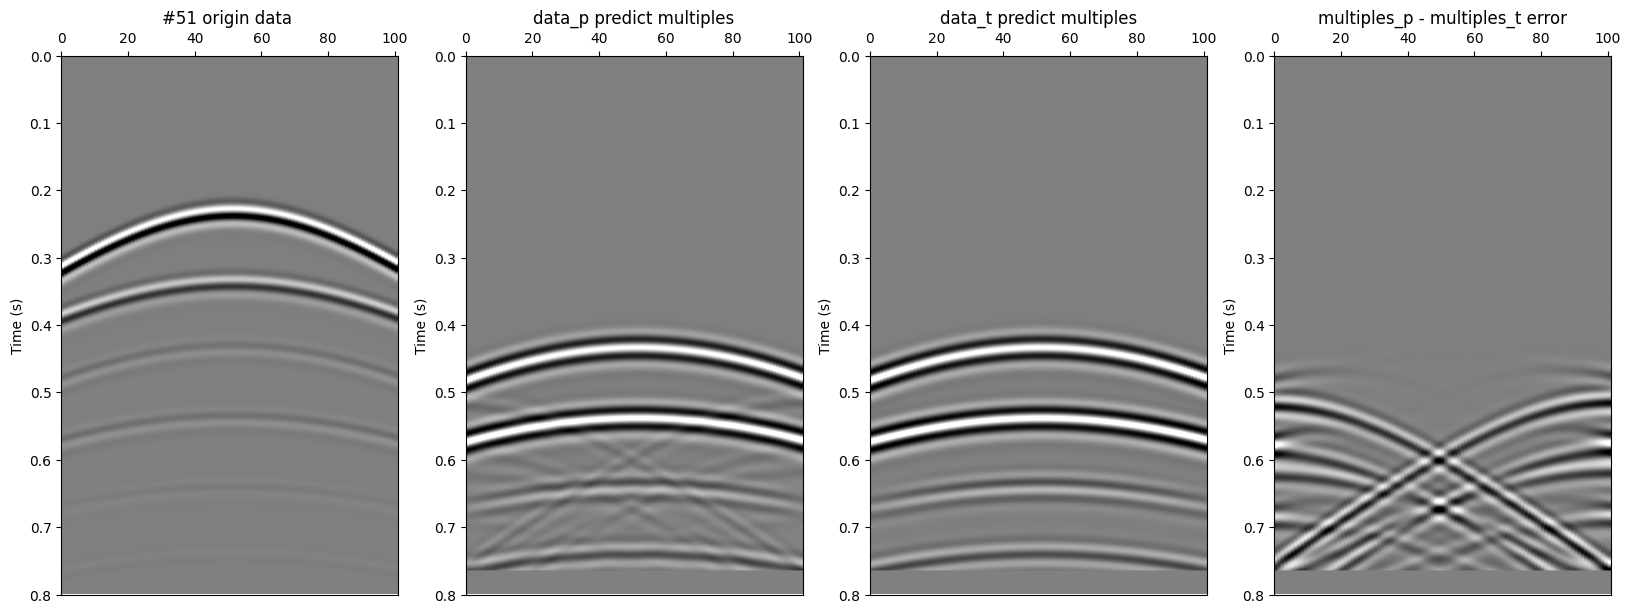

In [59]:
fig, axs = plt.subplots(1, 4, figsize=(20, 7))

axs[0].imshow(
    data_mutter[isrc,: , :].T,
    cmap="gray",
    vmin=-pclip * np.abs(data_mutter[isrc, :, :]).max(),
    vmax=pclip * np.abs(data_mutter[isrc, :, :]).max(),
    extent=(0, nr, nt*dt*1e-3, 0)
)
axs[0].set(ylabel="Time (s)", title="#51 origin data ")
axs[0].xaxis.set_ticks_position('top')
axs[0].axis("tight")

axs[1].imshow(
    multiples_shift_p[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(multiples_shift_p[isrc, :, :]).max(),
    vmax=pclip * np.abs(multiples_shift_p[isrc, :, :]).max(),
    extent=(0, nr, nt*dt*1e-3, 0)
)
axs[1].set(ylabel="Time (s)", title="data_p predict multiples")
axs[1].xaxis.set_ticks_position('top')
axs[1].axis("tight")

axs[2].imshow(
    multiples_shift_t[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(multiples_shift_t[isrc, :, :]).max(),
    vmax=pclip * np.abs(multiples_shift_t[isrc, :, :]).max(),
    extent=(0, nr, nt*dt*1e-3, 0)
)
axs[2].set(ylabel="Time (s)", title="data_t predict multiples")
axs[2].xaxis.set_ticks_position('top')
axs[2].axis("tight")

error = multiples_shift_p - multiples_shift_t
axs[3].imshow(
    error[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(error[isrc, :, :]).max(),
    vmax=pclip * np.abs(error[isrc, :, :]).max(),
    extent=(0, nr, nt*dt*1e-3, 0)
)
axs[3].set(ylabel="Time (s)", title="multiples_p - multiples_t error")
axs[3].xaxis.set_ticks_position('top')
axs[3].axis("tight")

### 6. Adaptive-subtraction

(np.float64(0.0), np.float64(101.0), np.float64(0.8), np.float64(0.0))

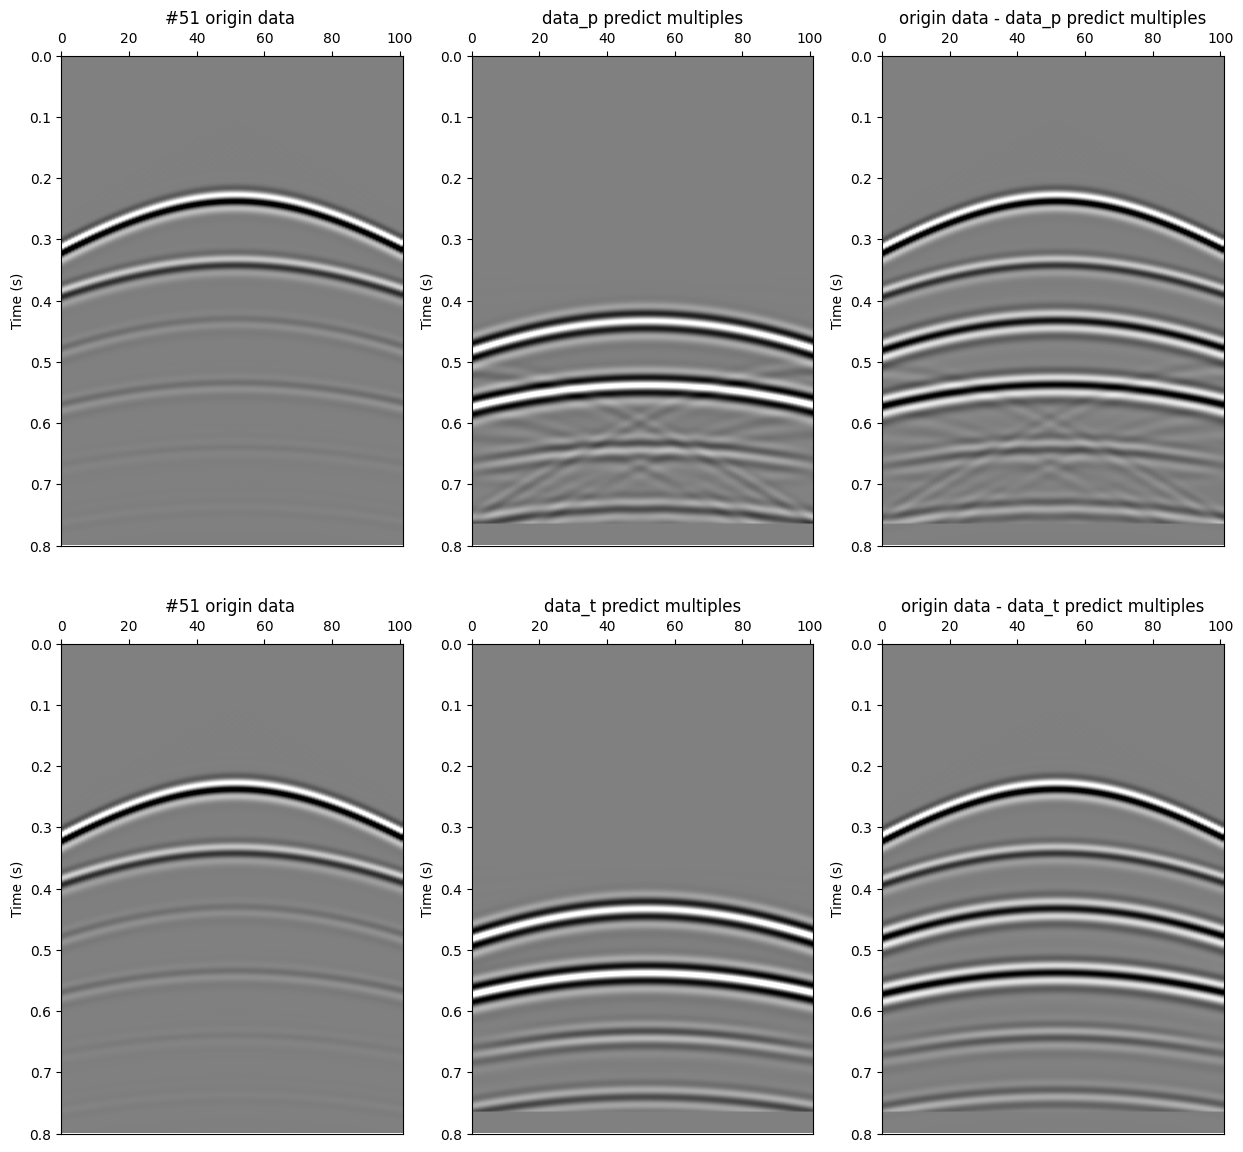

In [60]:
fig, axs = plt.subplots(2, 3, figsize=(15, 14))

axs[0, 0].imshow(
    data_mutter[isrc,: , :].T,
    cmap="gray",
    vmin=-pclip * np.abs(data_mutter[isrc, :, :]).max(),
    vmax=pclip * np.abs(data_mutter[isrc, :, :]).max(),
    extent=(0, nr, nt*dt*1e-3, 0)
)
axs[0, 0].set(ylabel="Time (s)", title="#51 origin data ")
axs[0, 0].xaxis.set_ticks_position('top')
axs[0, 0].axis("tight")

axs[0, 1].imshow(
    multiples_shift_p[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(multiples_shift_p[isrc, :, :]).max(),
    vmax=pclip * np.abs(multiples_shift_p[isrc, :, :]).max(),
    extent=(0, nr, nt*dt*1e-3, 0)
)
axs[0, 1].set(ylabel="Time (s)", title="data_p predict multiples")
axs[0, 1].xaxis.set_ticks_position('top')
axs[0, 1].axis("tight")

primairies_p = data_mutter - multiples_shift_p
axs[0, 2].imshow(
    primairies_p[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(primairies_p[isrc, :, :]).max(),
    vmax=pclip * np.abs(primairies_p[isrc, :, :]).max(),
    extent=(0, nr, nt*dt*1e-3, 0)
)
axs[0, 2].set(ylabel="Time (s)", title="origin data - data_p predict multiples")
axs[0, 2].xaxis.set_ticks_position('top')
axs[0, 2].axis("tight")

axs[1, 0].imshow(
    data_mutter[isrc,: , :].T,
    cmap="gray",
    vmin=-pclip * np.abs(data_mutter[isrc, :, :]).max(),
    vmax=pclip * np.abs(data_mutter[isrc, :, :]).max(),
    extent=(0, nr, nt*dt*1e-3, 0)
)
axs[1, 0].set(ylabel="Time (s)", title="#51 origin data ")
axs[1, 0].xaxis.set_ticks_position('top')
axs[1, 0].axis("tight")

axs[1, 1].imshow(
    multiples_shift_t[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(multiples_shift_t[isrc, :, :]).max(),
    vmax=pclip * np.abs(multiples_shift_t[isrc, :, :]).max(),
    extent=(0, nr, nt*dt*1e-3, 0)
)
axs[1, 1].set(ylabel="Time (s)", title="data_t predict multiples")
axs[1, 1].xaxis.set_ticks_position('top')
axs[1, 1].axis("tight")

primairies_t = data_mutter - multiples_shift_t
axs[1, 2].imshow(
    primairies_t[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(primairies_t[isrc, :, :]).max(),
    vmax=pclip * np.abs(primairies_t[isrc, :, :]).max(),
    extent=(0, nr, nt*dt*1e-3, 0)
)
axs[1, 2].set(ylabel="Time (s)", title="origin data - data_t predict multiples")
axs[1, 2].xaxis.set_ticks_position('top')
axs[1, 2].axis("tight")

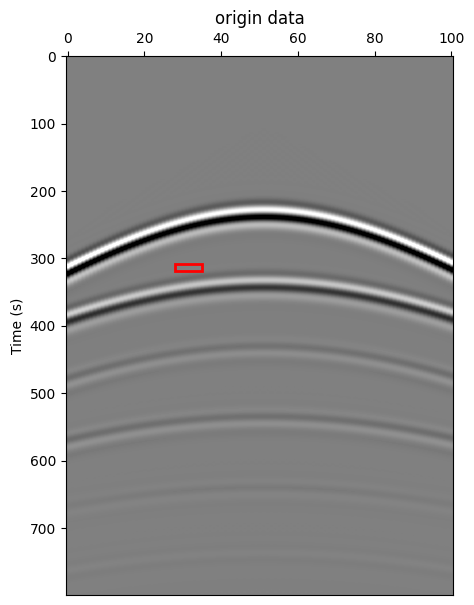

-0.33821666 0.28884816
-0.22268835 0.30056563


In [61]:
nwin = (7, 11)

fig, axs = plt.subplots(1, 1, figsize=(5, 7))
axs.imshow(
    data_mutter[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(data_mutter[isrc, :, :]).max(),
    vmax=pclip * np.abs(data_mutter[isrc, :, :]).max(),
)
axs.set(ylabel="Time (s)", title="origin data")
axs.xaxis.set_ticks_position('top')
axs.axis("tight")

# Define the coordinates for the red rectangle
x0, y0 = 4*nwin[0], 28*nwin[1]  # starting point
width, height = nwin[0], nwin[1]  # width and height of the rectangle

# Create the rectangle and add it to the plot
rect = Rectangle((x0, y0), width, height, linewidth=2, edgecolor='r', facecolor='none')
axs.add_patch(rect)

plt.show()

print(np.min(data_mutter), np.max(data_mutter))
print(np.min(multiples_shift_p), np.max(multiples_shift_p))

### 6. Adaptive-subtraction(LSQR)

In [62]:
from uilts.adasubtraction import adasubtraction_lsqr

# lsqr_prim_matrix_p, lsqr_mult_matrix_p = adasubtraction_lsqr(data_mutter, multiples_shift_p, nwin, 10, 1e-1)

# lsqr_prim_matrix_t, lsqr_mult_matrix_t = adasubtraction_lsqr(data_mutter, multiples_shift_t, nwin, 10, 1e-1)

In [63]:
# np.savez('../data/lsqr_prim_p.npz', lsqr_prim_matrix_p)
# np.savez('../data/lsqr_mult_p.npz', lsqr_mult_matrix_p)

# np.savez('../data/lsqr_prim_t.npz', lsqr_prim_matrix_t)
# np.savez('../data/lsqr_mult_t.npz', lsqr_mult_matrix_t)

lsqr_prim_matrix_p = np.load('../data/lsqr_prim_p.npz')['arr_0']
lsqr_mult_matrix_p = np.load('../data/lsqr_mult_p.npz')['arr_0']

lsqr_prim_matrix_t = np.load('../data/lsqr_prim_t.npz')['arr_0']
lsqr_mult_matrix_t = np.load('../data/lsqr_mult_t.npz')['arr_0']

(np.float64(0.0), np.float64(101.0), np.float64(0.8), np.float64(0.0))

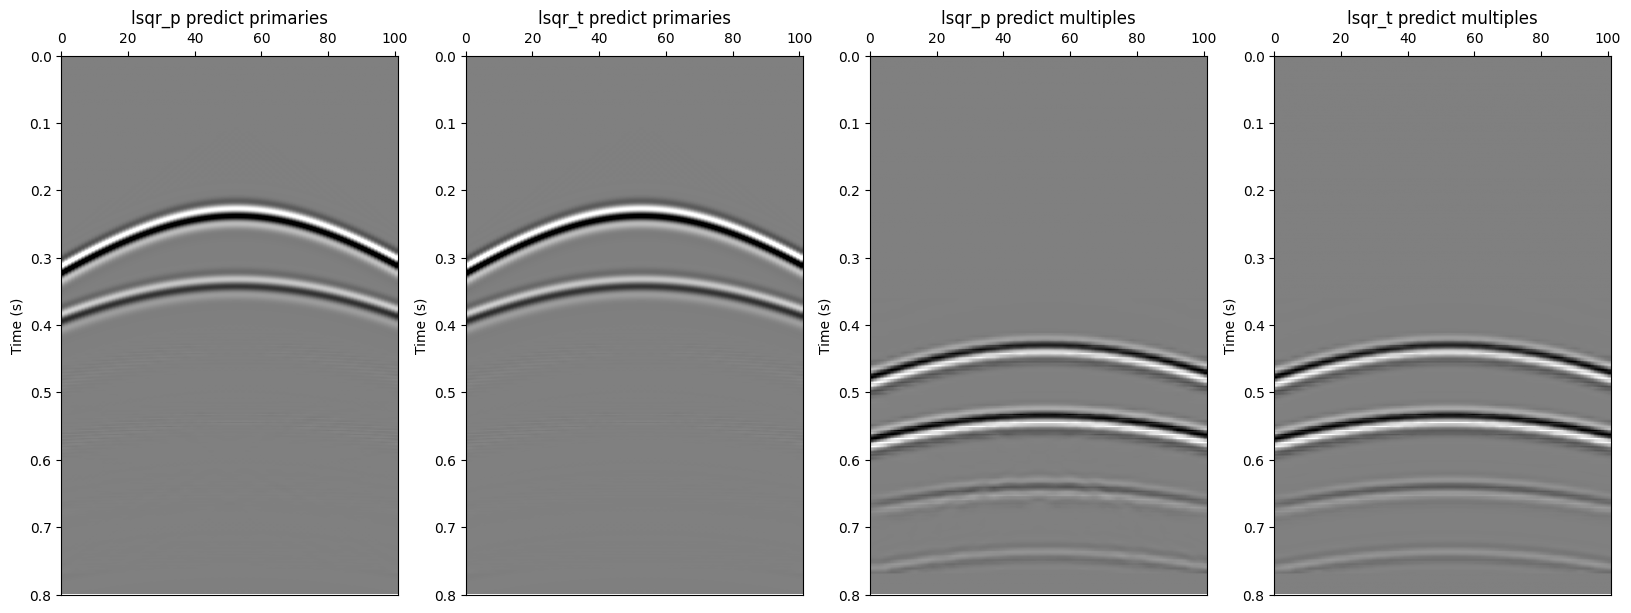

In [64]:
fig, axs = plt.subplots(1, 4, figsize=(20, 7))
axs[0].imshow(
    lsqr_prim_matrix_p[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(lsqr_prim_matrix_p[isrc, :, :]).max(),
    vmax=pclip * np.abs(lsqr_prim_matrix_p[isrc, :, :]).max(),
    extent=(0, nr, nt * dt * 1e-3, 0),
)
axs[0].set(ylabel="Time (s)", title="lsqr_p predict primaries")
axs[0].xaxis.set_ticks_position('top')
axs[0].axis("tight")

axs[1].imshow(
    lsqr_prim_matrix_t[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(lsqr_prim_matrix_t[isrc, :, :]).max(),
    vmax=pclip * np.abs(lsqr_prim_matrix_t[isrc, :, :]).max(),
    extent=(0, nr, nt * dt * 1e-3, 0),
)
axs[1].set(ylabel="Time (s)", title="lsqr_t predict primaries")
axs[1].xaxis.set_ticks_position('top')
axs[1].axis("tight")

axs[2].imshow(
    lsqr_mult_matrix_p[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(lsqr_mult_matrix_p[isrc, :, :]).max(),
    vmax=pclip * np.abs(lsqr_mult_matrix_p[isrc, :, :]).max(),
    extent=(0, nr, nt * dt * 1e-3, 0),
)
axs[2].set(ylabel="Time (s)", title="lsqr_p predict multiples")
axs[2].xaxis.set_ticks_position('top')
axs[2].axis("tight")

axs[3].imshow(
    lsqr_mult_matrix_t[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(lsqr_mult_matrix_t[isrc, :, :]).max(),
    vmax=pclip * np.abs(lsqr_mult_matrix_t[isrc, :, :]).max(),
    extent=(0, nr, nt * dt * 1e-3, 0),
)
axs[3].set(ylabel="Time (s)", title="lsqr_t predict multiples")
axs[3].xaxis.set_ticks_position('top')
axs[3].axis("tight")

(np.float64(0.0), np.float64(101.0), np.float64(0.8), np.float64(0.0))

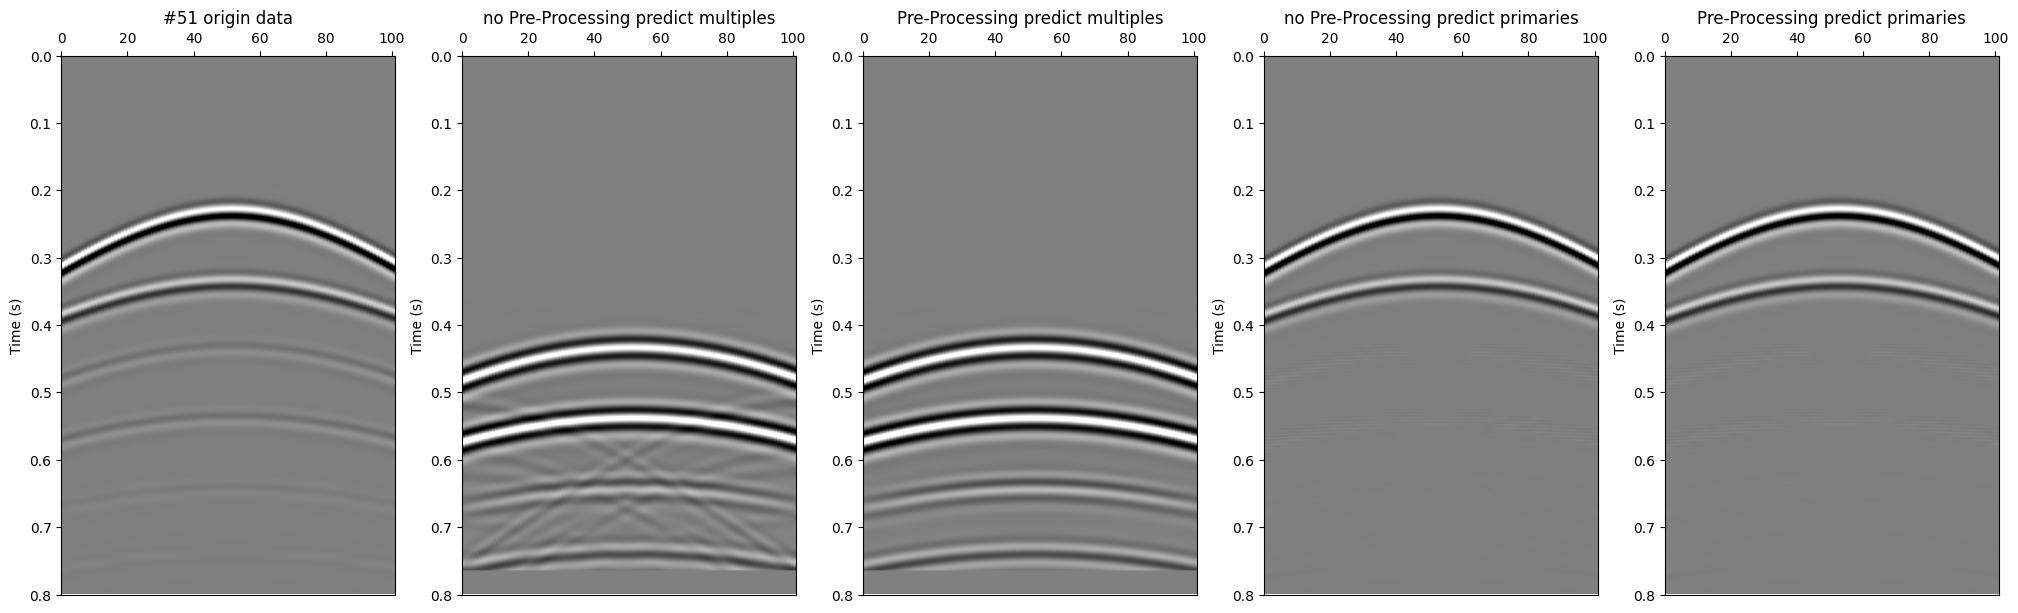

In [66]:
fig, axs = plt.subplots(1, 5, figsize=(25, 7))

axs[0].imshow(
    data_mutter[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(data_mutter[isrc, :, :]).max(),
    vmax=pclip * np.abs(data_mutter[isrc, :, :]).max(),
    extent=(0, nr, nt * dt * 1e-3, 0),
)
axs[0].set(ylabel="Time (s)", title="#51 origin data")
axs[0].xaxis.set_ticks_position('top')
axs[0].axis("tight")

axs[1].imshow(
    multiples_shift_p[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(multiples_shift_p[isrc, :, :]).max(),
    vmax=pclip * np.abs(multiples_shift_p[isrc, :, :]).max(),
    extent=(0, nr, nt * dt * 1e-3, 0),
)
axs[1].set(ylabel="Time (s)", title="no Pre-Processing predict multiples")
axs[1].xaxis.set_ticks_position('top')
axs[1].axis("tight")

axs[2].imshow(
    multiples_shift_t[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(multiples_shift_t[isrc, :, :]).max(),
    vmax=pclip * np.abs(multiples_shift_t[isrc, :, :]).max(),
    extent=(0, nr, nt * dt * 1e-3, 0),
)
axs[2].set(ylabel="Time (s)", title="Pre-Processing predict multiples")
axs[2].xaxis.set_ticks_position('top')
axs[2].axis("tight")

axs[3].imshow(
    lsqr_prim_matrix_p[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(lsqr_prim_matrix_p[isrc, :, :]).max(),
    vmax=pclip * np.abs(lsqr_prim_matrix_p[isrc, :, :]).max(),
    extent=(0, nr, nt * dt * 1e-3, 0),
)
axs[3].set(ylabel="Time (s)", title="no Pre-Processing predict primaries")
axs[3].xaxis.set_ticks_position('top')
axs[3].axis("tight")

axs[4].imshow(
    lsqr_prim_matrix_t[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(lsqr_prim_matrix_t[isrc, :, :]).max(),
    vmax=pclip * np.abs(lsqr_prim_matrix_t[isrc, :, :]).max(),
    extent=(0, nr, nt * dt * 1e-3, 0),
)
axs[4].set(ylabel="Time (s)", title="Pre-Processing predict primaries")
axs[4].xaxis.set_ticks_position('top')
axs[4].axis("tight")